## Delineate basins

The first step when building a model is to define the model domain. For hydrological models this is typically a full **basin** or **subbasin** which includes all upstream cells. For hydrodynamic models it often makes sense to use an **interbasin** to ensure that the same river only enters the model domain once. *hydroMT* has the `get_basin_geometry` function to do just that. 

### Import packages

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
from shapely.geometry import box
from pprint import pprint

In [2]:
# for plotting
import matplotlib.pyplot as plt
from matplotlib import colors, patheffects
import cartopy.io.img_tiles as cimgt
import cartopy.crs as ccrs
proj = ccrs.PlateCarree() # plot projection

In [3]:
# import hydromt
import hydromt
from hydromt.workflows.basin_mask import get_basin_geometry

In [4]:
# setup logging
from  hydromt.log import setuplog
logger = setuplog("basin_delineation", log_level=10)

2021-04-28 14:23:01,761 - basin_delineation - log - INFO - HydroMT version: 0.4.1.dev


### Read data

Read data using the `DataCatalog`. If no yml files with data sources are provided, by default data for the Piave basin is downloaded from the hydromt-artifacts to to `~/.hydromt_data/`. Links to the original data sources and data licenses can be found in the meta dict of each source. Here we use flow direction data from [MERIT Hydro](http://hydro.iis.u-tokyo.ac.jp/~yamadai/MERIT_Hydro). Note that the original `'MERIT Hydro'` data has been extended with a basin mask layer,
which together with the basin index vector data makes faster basin delineation possible.

In [5]:
# instantiate instance of Data Catalog
data_catalog = hydromt.DataCatalog(logger=logger)

In [6]:
# read MERIT hydro flow direction data
pprint(data_catalog["merit_hydro"].meta)
ds = data_catalog.get_rasterdataset("merit_hydro") 

2021-04-28 14:23:01,774 - basin_delineation - data_adapter - INFO - Downloading file to /home/runner/.hydromt_data/data/v0.0.3/data.tar.gz


2021-04-28 14:23:02,839 - basin_delineation - data_adapter - DEBUG - Unpacking data from /home/runner/.hydromt_data/data/v0.0.3/data.tar.gz


2021-04-28 14:23:04,162 - basin_delineation - data_adapter - INFO - Updating data sources from yml file /home/runner/.hydromt_data/data/v0.0.3/data_catalog.yml


{'category': 'topography',
 'paper_doi': '10.1029/2019WR024873',
 'paper_ref': 'Yamazaki et al. (2019)',
 'source_license': 'CC-BY-NC 4.0 or ODbL 1.0',
 'source_url': 'http://hydro.iis.u-tokyo.ac.jp/~yamadai/MERIT_Hydro',
 'source_version': 1.0}
2021-04-28 14:23:04,237 - basin_delineation - data_adapter - INFO - DataCatalog: Getting merit_hydro RasterDataset raster data from /home/runner/.hydromt_data/data/v0.0.3/merit_hydro/{variable}.tif


In [7]:
# read MERIT hydro basin index vector data
# Here we pass the GeoDataFrameAdapter instead of the GeoDataFrame itself 
# to load the relevant area within the get_basin_geometry method
pprint(data_catalog["merit_hydro_index"].meta)
bas_index = data_catalog["merit_hydro_index"]

{'category': 'topography',
 'paper_doi': '10.5194/hess-2020-582',
 'paper_ref': 'Eilander et al. (in review)',
 'source_license': 'CC-BY-NC 4.0'}


In [8]:
# derive river geometry based on stream order >= 7 (for plotting only)
flwdir = hydromt.flw.flwdir_from_da(ds['flwdir'], ftype='d8')
feats = flwdir.streams(mask=ds['strord']>=7)
gdf_riv = gpd.GeoDataFrame.from_features(feats).set_index("idxs")

### Delineate basins

Several examples to delineate sub-, inter- or full basins are provided below. Together with the command line interface (CLI) syntax for the `hydromt build` command. All CLI options are described in the `parse_region` method.

Get the basin based on a point location `[x, y]`.

In [9]:
# CLI syntax: {'basin': [x, y]}

xy=[12.6, 45.8]
gdf_xy = gpd.GeoDataFrame(geometry=gpd.points_from_xy(x=[xy[0]], y=[xy[1]]), crs=4326)
gdf_bas, _ = get_basin_geometry(
    ds,
    kind='basin',
    xy=xy,
    basin_index=bas_index,
    logger=logger,
)

2021-04-28 14:23:08,365 - basin_delineation - basin_mask - DEBUG - Getting basin IDs at point locations.


2021-04-28 14:23:08,446 - basin_delineation - basin_mask - INFO - basin bbox: [12.1958, 45.5850, 12.8983, 46.4167] / size: 408029


<GeoAxesSubplot:>

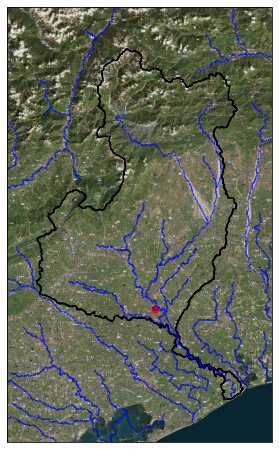

In [10]:
# plot results
extent = np.array(gdf_bas.buffer(0.1).total_bounds)[[0, 2, 1, 3]]
fig = plt.figure(figsize=(6,8))
ax = plt.subplot(projection=proj)
ax.set_extent(extent, crs=proj)
ax.add_image(cimgt.QuadtreeTiles(), 12)
gdf_bas.boundary.plot(ax=ax, edgecolor='k')
gdf_riv.plot(ax=ax, color='blue', alpha=0.7)
gdf_xy.plot(ax=ax, markersize=40, c='red')

### Delineate subbasins

We need an intial bounding box to delineate the subbasin. This can be derived from the *merit_hydro_index* or user provided intitial `bounds`. The latter might be faster if delineating a small subbasin from a large basin. A warning is raised if not all contributing cells are included.

Get a subbasin based on its outlet location `[x,y]`, snapped to a stream defined by a `<variable>:<threshold>` pair, in this case a stream order larger or equal to 7. The `variable` should be present in the dataset `ds`. 

In [11]:
# {'subbasin': [x, y], <variable>: <threshold>, 'bounds': [xmin, ymin, xmax, ymax]}

bounds = [12.1, 45.5, 12.9, 46.5]
gdf_bounds = gpd.GeoDataFrame(geometry=[box(*bounds)], crs=4326)
gdf_bas, gdf_out = get_basin_geometry(
    ds,
    kind='subbasin',
    xy=xy,
    strord=7,
#     basin_index=bas_index,
    bounds=bounds,
    logger=logger,
)

2021-04-28 14:23:29,619 - basin_delineation - basin_mask - INFO - basin bbox: [12.2350, 45.7950, 12.8783, 46.4167] / size: 293449


<GeoAxesSubplot:>

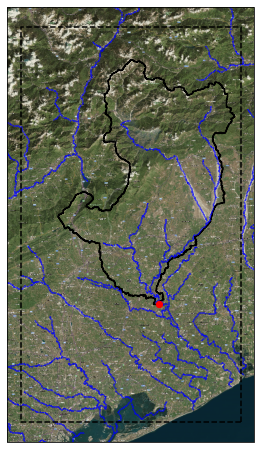

In [12]:
# plot results
extent = gdf_bounds.buffer(0.05).total_bounds[[0, 2, 1, 3]]
fig = plt.figure(figsize=(6,8))
ax = plt.subplot(projection=proj)
ax.set_extent(extent, crs=proj)
ax.add_image(cimgt.QuadtreeTiles(), 12)
gdf_bas.boundary.plot(ax=ax, edgecolor='k')
gdf_riv.plot(ax=ax, color='blue', alpha=0.7)
gdf_out.plot(ax=ax, markersize=40, c='red', zorder=2)
gdf_bounds.boundary.plot(ax=ax, edgecolor='k', ls='--')

Get a subbasin based on the location where the stream flows out of a `bbox`. Here the stream defined by a `<variable>:<threshold>` pair, in this case a stream order larger or equal to 8. The `variable` should be present in the dataset `ds`. 

In [13]:
# {'subbasin': [xmin, ymin, xmax, ymax], <variable>: <threshold>, 'bounds': [xmin, ymin, xmax, ymax]}
bbox = [12.50, 45.72, 12.7, 46]
gdf_bbox = gpd.GeoDataFrame(geometry=[box(*bbox)], crs=4326)
gdf_bas, gdf_out = get_basin_geometry(
    ds,
    kind='subbasin',
    bbox=bbox,
    strord=8,
    bounds=bounds,
    logger=logger,
)

2021-04-28 14:23:41,621 - basin_delineation - basin_mask - INFO - basin bbox: [12.1958, 45.7192, 12.8783, 46.4167] / size: 400335


<GeoAxesSubplot:>

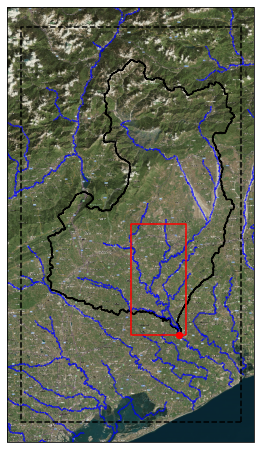

In [14]:
# plot results
extent = gdf_bounds.buffer(0.05).total_bounds[[0, 2, 1, 3]]
fig = plt.figure(figsize=(6,8))
ax = plt.subplot(projection=proj)
ax.set_extent(extent, crs=proj)
ax.add_image(cimgt.QuadtreeTiles(), 12)
gdf_bas.boundary.plot(ax=ax, edgecolor='k')
gdf_riv.plot(ax=ax, color='blue', alpha=0.7)
gdf_out.plot(ax=ax, markersize=40, c='red', zorder=2)
gdf_bbox.boundary.plot(ax=ax, edgecolor='r', ls='-')
gdf_bounds.boundary.plot(ax=ax, edgecolor='k', ls='--')

### Delineate interbasins

Get an interbasin based on the streams within a `bbox`. The interbasin is limited to the most downstream contiguous area within the bbox that drains to the stream.  Here the stream defined by a `<variable>:<threshold>` pair, in this case a stream order larger or equal to 8. The `variable` should be present in the dataset `ds`. The `buffer` is required to check wether streams flow in and out of the bbox. 

In [15]:
# {'interbasin': [xmin, ymin, xmax, ymax], <variable>: <threshold>}
gdf_bas, gdf_out = get_basin_geometry(
    ds,
    kind='interbasin',
    bbox=bbox,
    strord=8,
    buffer=20,
    logger=logger,
)

2021-04-28 14:23:53,438 - basin_delineation - basin_mask - INFO - basin bbox: [12.5000, 45.7200, 12.7000, 46.0000] / size: 63515


<GeoAxesSubplot:>

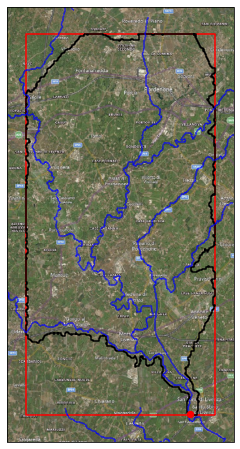

In [16]:
# plot results
extent = gdf_bbox.buffer(0.02).total_bounds[[0, 2, 1, 3]]
fig = plt.figure(figsize=(6,8))
ax = plt.subplot(projection=proj)
ax.set_extent(extent, crs=proj)
ax.add_image(cimgt.QuadtreeTiles(), 12)
gdf_bas.boundary.plot(ax=ax, edgecolor='k', zorder=2)
gdf_riv.plot(ax=ax, color='blue', alpha=0.7)
gdf_out.plot(ax=ax, markersize=40, c='red', zorder=2)
gdf_bbox.boundary.plot(ax=ax, edgecolor='r', ls='-', zorder=1)
gdf_bounds.boundary.plot(ax=ax, edgecolor='k', ls='--', zorder=1)